In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nptdms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nptdms: filename=nptdms-1.10.0-py3-none-any.whl size=108456 sha256=c5913158ac821bb704f1649cdabfe228b213ed772a7549313f802f2f5e1af586
  Stored in directory: /root/.cache/pip/wheels/1b/4b/17/21e8b03b37ea51ce7ec9f5570cdf0decca93f537d61c06880f
Successfully built nptdms


## CNN+LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
from scipy.fft import rfft
import pywt
from nptdms import TdmsFile
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
import joblib

import pandas as pd
from sklearn.linear_model import LinearRegression

from tensorflow.keras import regularizers

### 데이터 전처리 파이프라인

In [ ]:
def load_tdms_file(file_path):
    tdms_file = TdmsFile.read(file_path)

    group_name_vibration = tdms_file.groups()[0].name
    group_name_operation = tdms_file.groups()[1].name

    vib_channels = tdms_file[group_name_vibration].channels()
    vib_data = {ch.name.strip(): ch.data for ch in vib_channels}

    operation_channels = tdms_file[group_name_operation].channels()
    operation_data = {ch.name.strip(): ch.data for ch in operation_channels}

    return vib_data, operation_data

RUL 라벨링

In [ ]:
# tdms 파일에서 operation data 불러오기
def get_train_folders(train_root):
    all_folders = os.listdir(train_root)
    train_folders = [f for f in all_folders if f.lower().startswith("train") and os.path.isdir(os.path.join(train_root, f))]
    return sorted(train_folders)

def load_summary_from_tdms(train_root, target_folders):
    summary = {}

    for folder in target_folders:
        folder_path = os.path.join(train_root, folder)
        tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tdms")])

        records = []

        for idx, tdms_file in enumerate(tdms_files):
            file_path = os.path.join(folder_path, tdms_file)
            _, operation_data = load_tdms_file(file_path)

            time_sec = idx * 600  # 10분 간격

            record = {
                "time_sec": time_sec,
                "TC SP Front[℃]": operation_data["TC SP Front[℃]"][0],
                "TC SP Rear[℃]": operation_data["TC SP Rear[℃]"][0],
                "Torque[Nm]": operation_data["Torque[Nm]"][0],
                "file_name": os.path.splitext(tdms_file)[0],  # 확장자 제거
                "folder": folder
            }
            records.append(record)

        df = pd.DataFrame(records)
        summary[folder] = df

    return summary

# 중단 조건 도달 여부
def check_stop_condition_met(df):
    # 조건 1: Torque ≤ -17 Nm
    torque_stop = df["Torque[Nm]"] <= -17

    # 조건 2: TC SP Front ≥ 200 or TC SP Rear ≥ 200
    temp_stop = (df["TC SP Front[℃]"] >= 200) | (df["TC SP Rear[℃]"] >= 200)

    # 어느 하나라도 만족하면 중단 조건 도달
    stop_condition_met = (torque_stop | temp_stop).any()
    return stop_condition_met

# 중단 조건에 도달한 data point가 없을 경우
# 선형 회귀 함수
def estimate_rul_from_temp_time_based(temp_values, start_index, interval_sec=600, file_id="Sample"):
    n = len(temp_values)
    x = np.arange(start_index, start_index + n) * interval_sec
    y = np.array(temp_values)

    x_reshaped = x.reshape(-1, 1)
    model = LinearRegression().fit(x_reshaped, y)
    m = model.coef_[0]
    c = model.intercept_

    if m <= 0:
        print(f"[{file_id}] Warning: Temperature is not increasing (slope ≤ 0).")
        return None, None

    estimated_failure_time_sec = (200 - c) / m
    rul_seconds = estimated_failure_time_sec - x[-1]

    if estimated_failure_time_sec < x[-1] or rul_seconds < 0:
        print(f"[{file_id}] Warning: Predicted failure is before current time. Invalid regression.")
        return None, None

    return estimated_failure_time_sec, rul_seconds

# Front, Rear 선택 함수
def choose_temp_column_closer_to_200(df, front_col, rear_col):
    # 마지막 측정값 기준으로 200도와의 절대 차이 비교 후 Front, Rear 선택
    front_diff = abs(df[front_col].iloc[-1] - 200)
    rear_diff = abs(df[rear_col].iloc[-1] - 200)
    if front_diff <= rear_diff:
        return front_col
    else:
        return rear_col

# 3/5 points 선택 함수
def select_best_rul_with_temp_choice(df, estimation_targets, train_id, threshold_r2=0.85, interval_sec=600):
    front_col, rear_col = estimation_targets[train_id]
    target_col = choose_temp_column_closer_to_200(df, front_col, rear_col)

    results = []

    for n in [3, 5]:
        temp_values = df[target_col].values[-n:]
        start_index = len(df) - n
        x = np.arange(start_index, start_index + n) * interval_sec
        y = np.array(temp_values)

        model = LinearRegression().fit(x.reshape(-1, 1), y)
        r2 = model.score(x.reshape(-1, 1), y)

        est_time, rul = estimate_rul_from_temp_time_based(
            temp_values=temp_values,
            start_index=start_index,
            interval_sec=interval_sec,
            file_id=f"{train_id}_{target_col}_last{n}"
        )

        if est_time is not None and rul is not None:
            results.append((r2, est_time, rul, n))

    # 우선 R²가 threshold 이상인 것 중 R²가 높은 것 선택
    filtered = [res for res in results if res[0] >= threshold_r2]

    if filtered:
        best = max(filtered, key=lambda x: x[0])
    elif results:
        best = max(results, key=lambda x: x[0])
    else:
        print(f"[{train_id}] No valid regression results.")
        return None, None, None

    r2, est_time, rul, used_n = best
    print(f"[{train_id} | {target_col}] Selected {used_n} points (R² = {r2:.4f}) → RUL = {rul:.1f} sec")
    return est_time, rul, used_n

def label_rul_by_estimation(summary, estimation_targets, threshold_r2=0.85, interval_sec=600):
    """
    중단 조건을 만족하지 않은 데이터셋에 대해 회귀 기반으로 RUL을 추정하여 라벨링합니다.
    입력 summary는 {TrainID: DataFrame} 형식입니다.
    """
    for train_id in estimation_targets.keys():
        df = summary[train_id]

        # 1. 회귀 기반으로 RUL 추정
        est_time, rul, used_n = select_best_rul_with_temp_choice(df,estimation_targets, train_id, threshold_r2, interval_sec)

        if est_time is None:
            print(f"[{train_id}] RUL 예측 실패로 라벨링하지 않음.")
            continue

        # 2. 라벨링
        df = df.copy()
        df['time_sec'] = np.arange(len(df)) * interval_sec
        df['RUL_sec'] = (est_time - df['time_sec']).clip(lower=0)

        # 3. 업데이트
        summary[train_id] = df

    return summary

# 중단 조건에 도달한 data point가 있을 경우
def label_rul_by_stopping(summary, interval_sec=600):
    """
    중단 조건 시점에 따라 RUL을 라벨링합니다.
    입력 summary는 {TrainID: DataFrame} 형식입니다.
    """
    for train_id, df in summary.items():
        df = df.copy()

        # 조건 1: Torque ≤ -17
        torque_stop_idx = df.index[df["Torque[Nm]"] <= -17]

        # 조건 2: TC SP Front ≥ 200 or TC SP Rear ≥ 200
        temp_stop_idx = df.index[
            (df["TC SP Front[℃]"] >= 200) | (df["TC SP Rear[℃]"] >= 200)
        ]

        # 가장 빠른 중단 시점 찾기
        all_stop_indices = pd.concat([pd.Series(torque_stop_idx), pd.Series(temp_stop_idx)]).sort_values()

        if not all_stop_indices.empty:
            failure_idx = all_stop_indices.iloc[0]
            failure_time_sec = df.loc[failure_idx, "time_sec"]
        else:
            failure_time_sec = df["time_sec"].max()

        # 라벨링
        df["RUL_sec"] = (failure_time_sec - df["time_sec"]).clip(lower=0)

        # 업데이트
        summary[train_id] = df

    return summary


def label_rul_pipeline(summary, estimation_targets, threshold_r2=0.85, interval_sec=600):
    """
    중단 조건 충족 여부에 따라 적절한 라벨링 방식 적용.
    - 중단 조건 만족: 조건 기반 라벨링
    - 중단 조건 불만족: 회귀 기반 추정 라벨링
    - estimation_targets: 중단 조건 불만족으로 회귀 예측이 필요한 데이터셋 dict
    """
    for train_id, df in summary.items():
      if check_stop_condition_met(df):
          updated = label_rul_by_stopping({train_id: df}, interval_sec=interval_sec)
          summary[train_id] = updated[train_id]
          print(f"[{train_id}] 조건 기반 라벨링 완료.")
      elif train_id in estimation_targets:
          updated = label_rul_by_estimation({train_id: df}, {train_id: estimation_targets[train_id]}, threshold_r2, interval_sec)
          summary[train_id] = updated[train_id]
          print(f"[{train_id}] 회귀 기반 라벨링 완료.")
      else:
          print(f"[{train_id}] 회귀 대상 정보가 없어 라벨링 생략.")

    return summary

# --------------------

train_root = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set"

# 모든 train 폴더 불러오기 -> targets 생성 (front_col, rear_col 딕셔너리)
train_folders = get_train_folders(train_root)
targets = {folder: ("TC SP Front[℃]", "TC SP Rear[℃]") for folder in train_folders}

# 데이터 로딩 -> summary 생성
summary = load_summary_from_tdms(train_root, train_folders)

# 중단 조건 만족 여부 판별 -> 조건 불만족 리스트 생성
estimation_targets = {}
for train_id, df in summary.items():
    if not check_stop_condition_met(df):
        estimation_targets[train_id] = targets[train_id]

# 라벨링 파이프라인 수행
summary = label_rul_pipeline(summary, estimation_targets, threshold_r2=0.85, interval_sec=600)

[Train1] 조건 기반 라벨링 완료.
[Train2 | TC SP Front[℃]] Selected 5 points (R² = 0.9353) → RUL = 215.7 sec
[Train2] 회귀 기반 라벨링 완료.
[Train3 | TC SP Front[℃]] Selected 3 points (R² = 0.7762) → RUL = 196.4 sec
[Train3] 회귀 기반 라벨링 완료.
[Train4] 조건 기반 라벨링 완료.
[Train5] 조건 기반 라벨링 완료.
[Train6 | TC SP Rear[℃]] Selected 5 points (R² = 0.7887) → RUL = 614.9 sec
[Train6] 회귀 기반 라벨링 완료.
[Train7] 조건 기반 라벨링 완료.
[Train8] 조건 기반 라벨링 완료.


In [ ]:
# vibration data와 합치기 위해 펼치기
def expand_summary_to_windows(summary_df, window_size=25600, overlap=0.5, fixed_total_samples=256000):
    step = int(window_size * (1 - overlap))
    num_windows = (fixed_total_samples - window_size) // step + 1
    expanded_rows = []

    for idx, row in summary_df.iterrows():
        file_name = row.get("file_name", None)
        folder = row.get("folder", None)

        if file_name is None:
            raise ValueError("summary_df에 'file_name' 컬럼이 없습니다.")
        if folder is None:
            raise ValueError("summary_df에 'folder' 컬럼이 없습니다.")

        for w in range(num_windows):
            new_row = row.copy()
            new_row["window_index"] = w
            new_row["file_name"] = file_name
            new_row["folder"] = folder
            expanded_rows.append(new_row)

    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# summary는 dict이므로 하나의 DataFrame으로 병합
summary_df = pd.concat(
    [df.assign(folder=train_id) for train_id, df in summary.items()],
    ignore_index=True
)

# 윈도우 단위로 확장
summary_expanded = expand_summary_to_windows(summary_df)


WPT+FFT

In [ ]:
# 슬라이딩 윈도우 분할 (window_size 샘플, overlap 비율)
def sliding_window(data, window_size=25600, overlap=0.5):
    step = int(window_size * (1 - overlap))
    return np.array([
        data[start:start + window_size]
        for start in range(0, len(data) - window_size + 1, step)
    ])  # (윈도우 수, window_size, 채널 수)

# 1차원 신호에 대해 WPT+FFT top_k 에너지 특징 추출
def extract_wpt_fft_features(signal, wavelet='db4', level=3, top_k=10):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = [node.path for node in wp.get_level(level, 'freq')]
    features = []
    for node in nodes:
        coeffs = wp[node].data
        fft_vals = np.abs(rfft(coeffs))
        top_features = np.sort(fft_vals)[-top_k:]
        features.extend(top_features)
    return np.array(features)  # (노드 수 × top_k, )

# TDMS 파일 경로로부터 진동 데이터 읽어, 윈도우별 WPT+FFT 특징 추출 함수
def extract_vibration_array_with_features(file_path, window_size=25600, overlap=0.5, wavelet='db4', level=3, top_k=10):
    vib_data, _ = load_tdms_file(file_path)
    channels = ["CH1", "CH2", "CH3", "CH4"]
    vib_arrays = [vib_data[ch] for ch in channels if ch in vib_data]
    vib_matrix = np.vstack(vib_arrays).T  # (샘플 수, 4)

    windows = sliding_window(vib_matrix, window_size=window_size, overlap=overlap)  # (윈도우 수, window_size, 4)

    all_features = []
    for window in windows:
        window_features = []
        for ch_idx in range(window.shape[1]):
            signal = window[:, ch_idx]
            feat = extract_wpt_fft_features(signal, wavelet=wavelet, level=level, top_k=top_k)
            window_features.extend(feat)
        all_features.append(window_features)

    return np.array(all_features)  # (윈도우 수, 채널 수 * 특징 수)

def process_all_train_folders(base_path, folder_names):
    all_feature_rows = []

    for folder_name in folder_names:
        folder_path = os.path.join(base_path, folder_name)
        tdms_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tdms')])

        for tdms_file in tdms_files:
            file_path = os.path.join(folder_path, tdms_file)
            features = extract_vibration_array_with_features(file_path)

            for i, feature in enumerate(features):
                all_feature_rows.append({
                    'file_name': tdms_file,
                    'window_index': i,
                    'features': feature,
                    'folder': folder_name
                })

    return pd.DataFrame(all_feature_rows)


# --- 설정값 ---
base_path = "/content/drive/MyDrive/KSPHM-data-challenge/Train Set"
folder_names = [f"Train{i}" for i in range(1, 9)]  # Train1 ~ Train8

# --- 특징 추출 수행 ---
features_df = process_all_train_folders(base_path, folder_names)

features_df['file_name'] = features_df['file_name'].str.replace(r'\.tdms$', '', regex=True)

print(f"총 윈도우 수: {len(features_df)}")


총 윈도우 수: 23351


병합

In [ ]:
print("summary_expanded columns:", summary_expanded.columns.tolist())
print("features_df columns:", features_df.columns.tolist())

summary_expanded columns: ['time_sec', 'TC SP Front[℃]', 'TC SP Rear[℃]', 'Torque[Nm]', 'RUL_sec', 'folder', 'window_index']
features_df columns: ['file_name', 'window_index', 'features', 'folder']


In [ ]:
# 1) 먼저 features_df와 summary_expanded가 모두 만들어졌다고 가정
# 2) key: ['folder', 'file_name', 'window_index']

merged_df = pd.merge(
    summary_expanded,
    features_df,
    on=['folder', 'file_name', 'window_index'],
    how='inner'  # 윈도우 단위로 완전히 겹치는 데이터만 남음
)

print("병합된 데이터 개수:", len(merged_df))
print(merged_df.columns)


병합된 데이터 개수: 23351
Index(['time_sec', 'TC SP Front[℃]', 'TC SP Rear[℃]', 'Torque[Nm]',
       'file_name', 'folder', 'RUL_sec', 'window_index', 'features'],
      dtype='object')


### 데이터 로드

In [ ]:
# --- 설정값 ---
data_dir = "Train Set"
window_size = 25600
overlap = 0.5
wavelet = 'db4'
level = 3
top_k = 10
sampling_rate = 25600
step = int(window_size * (1 - overlap))

X = np.stack(merged_df['features'].values)
X = X[..., np.newaxis]

y = merged_df['RUL_sec'].values

# --- 데이터 스케일링 ---
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# X는 2D 배열이어야 하므로 reshape 후 스케일링
samples, feat_dim, channels = X.shape
X_reshaped = X.reshape(samples, feat_dim * channels)  # (samples, feat_dim*channels)
X_scaled = X_scaler.fit_transform(X_reshaped)

# y는 2D로 만들어서 스케일링
y_scaled = y_scaler.fit_transform(y.reshape(-1,1))

# 다시 모델 입력에 맞게 reshape
X_train_final = X_scaled.reshape(samples, feat_dim, channels)
y_train_final = y_scaled

print(f"X_train_final shape: {X_train_final.shape}, y_train_final shape: {y_train_final.shape}")

X_train_final shape: (23351, 320, 1), y_train_final shape: (23351, 1)


In [ ]:
import joblib


# 저장 경로
scaler_dir = "/content/drive/MyDrive/KSPHM-data-challenge/scalers"

# 저장
joblib.dump(X_scaler, os.path.join(scaler_dir, "X_scaler.pkl"))
joblib.dump(y_scaler, os.path.join(scaler_dir, "y_scaler.pkl"))

['/content/drive/MyDrive/KSPHM-data-challenge/scalers/y_scaler.pkl']

### CNN+LSTM

In [ ]:
from tensorflow.keras import regularizers

# --- 단일 Conv1D + LSTM 모델 정의 ---
def simplified_conv1d_lstm_model(input_shape):
    # input_shape는 (total_features_per_window, 1)이 됩니다. (예: (329, 1))
    input_layer = Input(shape=(input_shape[0], 1))

    # 단일 Conv1D 레이어
    x = Conv1D(filters=16, kernel_size=8, strides=1, padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)
    x = Dropout(0.15)(x)
    x = Conv1D(filters=8, kernel_size=4, strides=1, padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)

    # GlobalMaxPooling1D 또는 Flatten 후 Reshape
    x_pooled = tf.keras.layers.GlobalMaxPooling1D()(x)

    # LSTM 입력은 3D (batch, timesteps, features)
    # 현재 x_pooled는 2D (batch, features) 이므로 timesteps=1 로 Reshape
    lstm_input = Reshape((1, x_pooled.shape[-1]))(x_pooled) # x_pooled.shape[-1]이 Conv1D 출력 features

    ## LSTM ##
    lstm_out = LSTM(32, return_sequences=False)(lstm_input) # LSTM 유닛 수 조절 가능
    dropout = Dropout(0.4)(lstm_out) # Dropout 비율 조절 가능

    # 출력층 (잔존 수명 예측: 회귀 문제 → 1차원 출력)
    output = Dense(1, activation='linear')(dropout)

    # 모델 정의
    model = Model(inputs=input_layer, outputs=output)
    return model

학습

In [ ]:
input_shape = X_train_final.shape[1:] # (total_features, 1)

model = simplified_conv1d_lstm_model(input_shape)

custom_adam_optimizer_1 = Adam(learning_rate=0.0001)
model.compile(optimizer=custom_adam_optimizer_1, loss='mse')
model.summary() # 모델 요약 출력

# 콜백 설정
early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 320, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 313, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 156, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 156, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 153, 8)         │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 76, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945 (23.22 KB)

 Trainable params: 5,945 (23.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1693 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0934 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0715 - val_loss: 0.0569 - learning_rate: 1.0000e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0612 - val_loss: 0.0650 - learning_rate: 1.0000e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0574 - val_loss: 0.0659 - learning_rate: 1.0000e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0555 - val_loss: 0.0785 - learning_rate: 1.0000e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0531 - val_loss: 0.0898 - learning_rate: 1.0000e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0514 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0501 - val_los

시각화

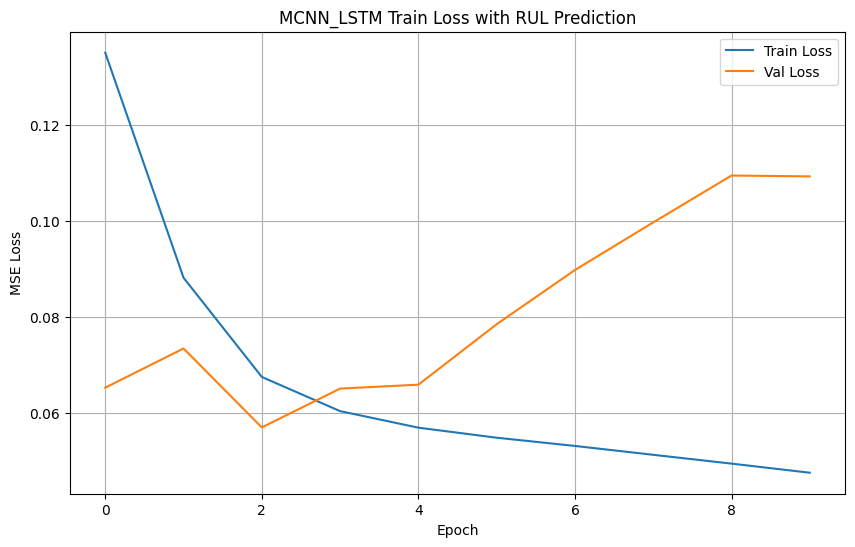

In [ ]:
# --- 결과 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MCNN_LSTM Train Loss with RUL Prediction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

### MLP

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers

def simple_mlp_model(input_shape):
    input_layer = Input(shape=(input_shape,))
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
# 원본 feature와 target
X = np.stack(merged_df['features'].values)  # shape: (num_samples, num_features)
y = merged_df['RUL_sec'].values             # shape: (num_samples,)

# 스케일링
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# MLP는 2D 입력을 받음 → reshape 불필요
X_train_final = X_scaled                    # shape: (samples, features)
y_train_final = y_scaled                    # shape: (samples, 1)

print("MLP용 X_train shape:", X_train_final.shape)
print("MLP용 y_train shape:", y_train_final.shape)

MLP용 X_train shape: (23351, 320)
MLP용 y_train shape: (23351, 1)


In [ ]:
model = simple_mlp_model(input_shape=X_train_final.shape[1])
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,169 (90.50 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1476 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 2/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0300 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 3/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0154 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 4/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0120 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 5/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0111 - val_loss: 0.1279 - learning_rate: 0.0010
Epoch 6/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 7/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0101 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 8/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch 9/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100 - val_loss: 0.1157 - learning_rate: 0.0010
E

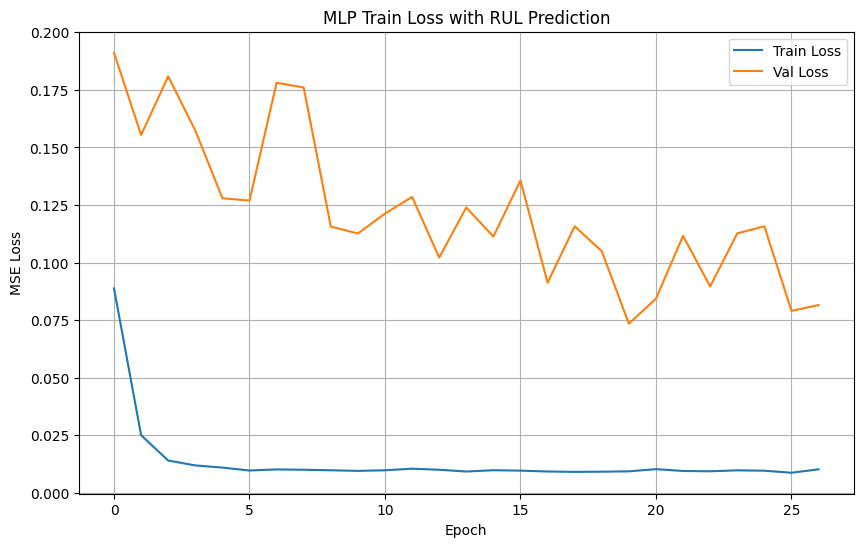

In [ ]:
# --- 결과 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Train Loss with RUL Prediction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

### CNN 1D

In [ ]:
def simplified_conv1d_model_without_lstm(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.005), padding='causal')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    x_flattened = Flatten()(x)

    output = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.005))(x_flattened)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
input_shape = X_train_final.shape[1:] # (total_features, 1)

model = simplified_conv1d_model_without_lstm(input_shape)

custom_adam_optimizer_1 = Adam(learning_rate=0.0001)
model.compile(optimizer=custom_adam_optimizer_1, loss='mse')
model.summary() # 모델 요약 출력

# 콜백 설정
early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr]
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 320, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 320, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 160, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 160, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │         2,561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,657 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1229 - val_loss: 0.2177 - learning_rate: 1.0000e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0455 - val_loss: 0.3874 - learning_rate: 1.0000e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0369 - val_loss: 0.4250 - learning_rate: 1.0000e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0320 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0291 - val_loss: 0.4746 - learning_rate: 1.0000e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - val_loss: 0.4701 - learning_rate: 1.0000e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0256 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 8/100
646/657 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.

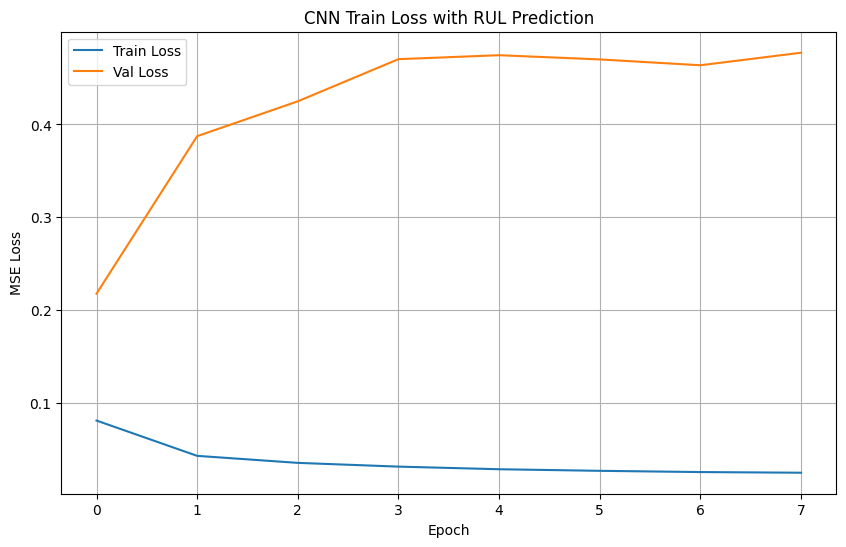

In [ ]:
# --- 결과 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Train Loss with RUL Prediction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

### CNN-LSTM simple version

In [ ]:
def simplified_conv1d_lstm_model_v1(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv1D(filters=8, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.005), padding='causal')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)

    lstm_out = LSTM(16, return_sequences=False,kernel_regularizer=regularizers.l2(0.005))(x)
    dropout_lstm = Dropout(0.3)(lstm_out)

    output = Dense(1, activation='linear')(dropout_lstm)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
input_shape = X_train_final.shape[1:] # (total_features, 1)

model = simplified_conv1d_lstm_model_v1(input_shape)

custom_adam_optimizer_1 = Adam(learning_rate=0.0001)
model.compile(optimizer=custom_adam_optimizer_1, loss='mse')
model.summary() # 모델 요약 출력

# 콜백 설정
early_stop = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 320, 8)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 160, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649 (6.44 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1999 - val_loss: 0.0976 - learning_rate: 1.0000e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.1032 - val_loss: 0.0749 - learning_rate: 1.0000e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0843 - val_loss: 0.0498 - learning_rate: 1.0000e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0719 - val_loss: 0.0304 - learning_rate: 1.0000e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0664 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0622 - val_loss: 0.0278 - learning_rate: 1.0000e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0602 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0590 - val_loss: 0.0209 - learning_rate: 1.0000e-04
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0576 - 

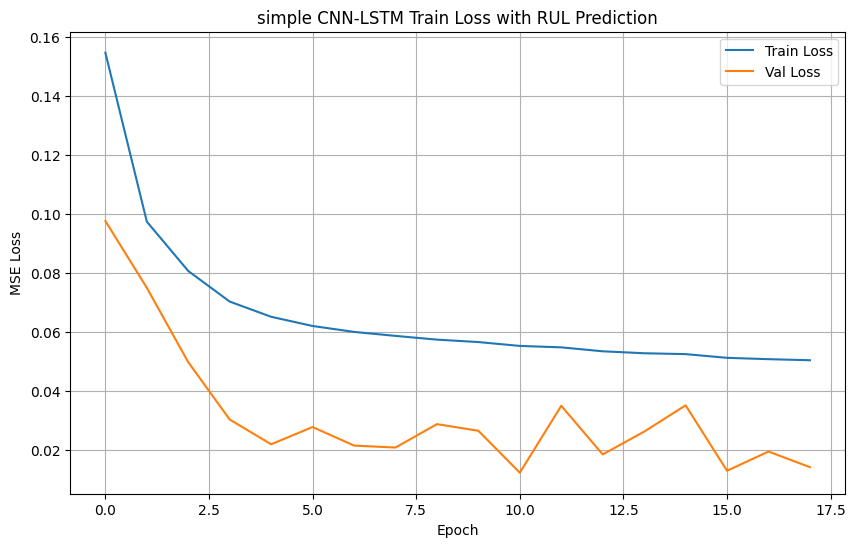

In [ ]:
# --- 결과 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('simple CNN-LSTM Train Loss with RUL Prediction')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

## 모델 저장

In [ ]:
# Google Drive 내에 저장할 디렉토리 경로
save_path = "/content/drive/MyDrive/KSPHM-data-challenge/model"
os.makedirs(save_path, exist_ok=True)

# 모델 저장
model.save(os.path.join(save_path, "simple_cnn_lstm_model.h5"))

print("모델이 'simple_cnn_lstm_model.h5'에 성공적으로 저장되었습니다.")

모델이 'simple_cnn_lstm_model.h5'에 성공적으로 저장되었습니다.
